In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
pip install transformers

In [4]:
import os
from huggingface_hub import login
from google.colab import userdata

# Accessing the secret key from Colab secrets
hf_token = userdata.get("HF_API_KEY")

if hf_token:
    login(token=hf_token)
else:
    raise ValueError("Hugging Face token not found in Colab secrets 'Colab_HF_token'")

In [5]:
import torch
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import os

**Load and Preprocess Training Data**

In [7]:
test_df = pd.read_csv('/content/drive/MyDrive/test (6).csv')
test_df.head()

,unique_id,time,x,y,red,nir,swir16,swir22,blue,green,rededge1,rededge2,rededge3,nir08
0,ID_01FHV4,2018-01-03 10:59:22.851,-296455.0,846395.0,0.2920,0.3686,0.4173,0.3869,0.2488,0.2708,0.3211,0.3555,0.3752,0.3862
1,ID_01FHV4,2018-01-03 10:59:22.851,-296455.0,846395.0,0.2920,0.3686,0.4173,0.3869,0.2488,0.2708,0.3211,0.3555,0.3752,0.3862
2,ID_01FHV4,2018-02-12 10:59:25.232,-296455.0,846395.0,0.3510,0.3426,0.4817,0.4577,0.2538,0.2914,0.3684,0.3484,0.3588,0.3628
3,ID_01FHV4,2018-02-12 10:59:25.232,-296455.0,846395.0,0.3510,0.3426,0.4817,0.4577,0.2538,0.2914,0.3684,0.3484,0.3588,0.3628
4,ID_01FHV4,2018-03-14 10:59:24.436,-296455.0,846395.0,0.5312,0.6296,0.6643,0.5882,0.5244,0.5308,0.6016,0.6217,0.6401,0.6404


In [6]:
train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Sentinel2_CropSamples_Reorganized.csv')
train_df.head()


,blue,crop_type,green,nir,nir08,red,rededge1,rededge2,rededge3,swir16,swir22,time,unique_id,x,y
0,559,cocoa,771,2404,2585,846,1240,2006,2326,2630,1684,2022-01-03,PIXEL_0001,0.957526,6.899852
1,537,cocoa,916,2448,2750,1096,1464,2124,2390,2851,1823,2022-01-08,PIXEL_0001,0.957526,6.899852
2,540,cocoa,877,2402,2498,1084,1415,1943,2184,3069,2100,2022-01-23,PIXEL_0001,0.957526,6.899852
3,1944,cocoa,2094,3076,3307,2260,2537,2809,3043,3887,2979,2022-01-28,PIXEL_0001,0.957526,6.899852
4,2062,cocoa,2092,2484,2599,2210,2293,2371,2529,2837,2275,2022-02-12,PIXEL_0001,0.957526,6.899852


In [8]:
train_df['crop_type'].value_counts()

,count
crop_type,
cocoa,6359
rubber,6283
oil,5800


In [9]:
from transformers import AutoModel, AutoConfig

model_name = "AminiTech/amini-28M-v1"

# Load model config and model (for PatchTST, not a language model!)
config = AutoConfig.from_pretrained(model_name, trust_remote_code=True)
model = AutoModel.from_pretrained(model_name, config=config, trust_remote_code=True)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/75.8M [00:00<?, ?B/s]

In [10]:
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

PatchTSTModel(
  (scaler): PatchTSTScaler(
    (scaler): PatchTSTMeanScaler()
  )
  (patchifier): PatchTSTPatchify()
  (masking): PatchTSTMasking()
  (encoder): PatchTSTEncoder(
    (embedder): PatchTSTEmbedding(
      (input_embedding): Linear(in_features=12, out_features=512, bias=True)
    )
    (positional_encoder): PatchTSTPositionalEncoding(
      (positional_dropout): Identity()
    )
    (layers): ModuleList(
      (0-5): 6 x PatchTSTEncoderLayer(
        (self_attn): PatchTSTAttention(
          (k_proj): Linear(in_features=512, out_features=512, bias=True)
          (v_proj): Linear(in_features=512, out_features=512, bias=True)
          (q_proj): Linear(in_features=512, out_features=512, bias=True)
          (out_proj): Linear(in_features=512, out_features=512, bias=True)
        )
        (dropout_path1): Identity()
        (norm_sublayer1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout_path2): Identity()
        (norm_sublayer2): LayerNorm((512,), 

In [11]:
import numpy as np

def mean_aggregator(cls_embeddings):
    """
    Fully averages all CLS embeddings, no splitting.
    Handles extra dimensions safely.

    Args:
        cls_embeddings: list or array of CLS tokens [n, 512] or [1, n, 512]
    Returns:
        final_embedding: mean [512]-dim vector
    """
    cls_embeddings = np.array(cls_embeddings)

    # Handle possible extra dimensions
    if cls_embeddings.ndim == 3 and cls_embeddings.shape[1] == 1:
        cls_embeddings = cls_embeddings.squeeze(1)
    elif cls_embeddings.ndim == 1:
        cls_embeddings = cls_embeddings.reshape(1, -1)  # shape: [1, 512]

    return np.mean(cls_embeddings, axis=0)


In [12]:
def generate_embeddings_sliding_window(df, model, max_length=48, stride=24):
    grouped = df.groupby('unique_id')
    all_embeddings = {}

    for unique_id, group in grouped:
        group = group.sort_values('time')
        features = group[['blue', 'green', 'nir', 'nir08', 'red', 'rededge1',
                          'rededge2', 'rededge3', 'swir16', 'swir22']].values
        sequence_length = len(features)
        print(f"[{unique_id}] Raw sequence length: {sequence_length}")

        # Normalize
        features = (features - features.mean(axis=0)) / (features.std(axis=0) + 1e-6)
        cls_list = []

        if sequence_length < max_length:
            # Pad to 48
            pad_len = max_length - sequence_length
            padding = np.zeros((pad_len, features.shape[1]))
            features_padded = np.vstack([features, padding])

            tensor_input = torch.tensor(features_padded, dtype=torch.float32).unsqueeze(0).to(device)
            print(f"[{unique_id}] Padded input shape: {tensor_input.shape}")

            with torch.no_grad():
                try:
                    output = model(tensor_input)
                    print(f"[{unique_id}] Output type: {type(output)}")
                    print(f"[{unique_id}] Output shape: {output.last_hidden_state.shape}")

                    # ✅ CLS patch (index 0), mean across bands
                    cls_token = output.last_hidden_state[:, :, 0, :].mean(dim=1).squeeze(0).cpu().numpy()
                    assert cls_token.shape == (512,)
                    cls_list.append(cls_token)

                except Exception as e:
                    print(f"[{unique_id}] Error during padded input: {type(e).__name__} - {e}")
                    continue

        else:
            # Sliding windows
            for i in range(0, sequence_length - max_length + 1, stride):
                window = features[i : i + max_length]
                tensor_input = torch.tensor(window, dtype=torch.float32).unsqueeze(0).to(device)
                print(f"[{unique_id}] Window {i} input shape: {tensor_input.shape}")

                with torch.no_grad():
                    try:
                        output = model(tensor_input)
                        print(f"[{unique_id}] Output type: {type(output)}")
                        print(f"[{unique_id}] Output shape: {output.last_hidden_state.shape}")

                        # ✅ CLS patch token = patch index 0
                        cls_token = output.last_hidden_state[:, :, 0, :].mean(dim=1).squeeze(0).cpu().numpy()
                        assert cls_token.shape == (512,)
                        cls_list.append(cls_token)

                    except Exception as e:
                        print(f"[{unique_id}] Error at window {i}: {type(e).__name__} - {e}")
                        continue

        if cls_list:
            cls_array = np.array(cls_list)
            print(f"[{unique_id}] CLS token array shape: {cls_array.shape}")  # e.g., (3, 512)
            all_embeddings[unique_id] = cls_list
        else:
            print(f"[{unique_id}] No CLS tokens generated")

    return all_embeddings


In [13]:
cls_embeddings = generate_embeddings_sliding_window(train_df, model, max_length=48, stride=24)

[PIXEL_0001] Raw sequence length: 54
[PIXEL_0001] Window 0 input shape: torch.Size([1, 48, 10])
[PIXEL_0001] Output type: <class 'transformers.models.patchtst.modeling_patchtst.PatchTSTModelOutput'>
[PIXEL_0001] Output shape: torch.Size([1, 10, 5, 512])
[PIXEL_0001] CLS token array shape: (1, 512)
[PIXEL_0002] Raw sequence length: 108
[PIXEL_0002] Window 0 input shape: torch.Size([1, 48, 10])
[PIXEL_0002] Output type: <class 'transformers.models.patchtst.modeling_patchtst.PatchTSTModelOutput'>
[PIXEL_0002] Output shape: torch.Size([1, 10, 5, 512])
[PIXEL_0002] Window 24 input shape: torch.Size([1, 48, 10])
[PIXEL_0002] Output type: <class 'transformers.models.patchtst.modeling_patchtst.PatchTSTModelOutput'>
[PIXEL_0002] Output shape: torch.Size([1, 10, 5, 512])
[PIXEL_0002] Window 48 input shape: torch.Size([1, 48, 10])
[PIXEL_0002] Output type: <class 'transformers.models.patchtst.modeling_patchtst.PatchTSTModelOutput'>
[PIXEL_0002] Output shape: torch.Size([1, 10, 5, 512])
[PIXEL_000

In [14]:
cls_embeddings_test = generate_embeddings_sliding_window(test_df, model, max_length=48, stride=24)

Streaming output truncated to the last 5000 lines.
[ID_YOBYMS] Output type: <class 'transformers.models.patchtst.modeling_patchtst.PatchTSTModelOutput'>
[ID_YOBYMS] Output shape: torch.Size([1, 10, 5, 512])
[ID_YOBYMS] Window 24 input shape: torch.Size([1, 48, 10])
[ID_YOBYMS] Output type: <class 'transformers.models.patchtst.modeling_patchtst.PatchTSTModelOutput'>
[ID_YOBYMS] Output shape: torch.Size([1, 10, 5, 512])
[ID_YOBYMS] Window 48 input shape: torch.Size([1, 48, 10])
[ID_YOBYMS] Output type: <class 'transformers.models.patchtst.modeling_patchtst.PatchTSTModelOutput'>
[ID_YOBYMS] Output shape: torch.Size([1, 10, 5, 512])
[ID_YOBYMS] Window 72 input shape: torch.Size([1, 48, 10])
[ID_YOBYMS] Output type: <class 'transformers.models.patchtst.modeling_patchtst.PatchTSTModelOutput'>
[ID_YOBYMS] Output shape: torch.Size([1, 10, 5, 512])
[ID_YOBYMS] Window 96 input shape: torch.Size([1, 48, 10])
[ID_YOBYMS] Output type: <class 'transformers.models.patchtst.modeling_patchtst.PatchTSTM

In [15]:
for uid, cls_list in cls_embeddings.items():
    arr = np.array(cls_list)
    print(f"{uid} → shape: {arr.shape}")


PIXEL_0001 → shape: (1, 512)
PIXEL_0002 → shape: (3, 512)
PIXEL_0003 → shape: (3, 512)
PIXEL_0004 → shape: (1, 512)
PIXEL_0005 → shape: (1, 512)
PIXEL_0006 → shape: (3, 512)
PIXEL_0007 → shape: (1, 512)
PIXEL_0008 → shape: (3, 512)
PIXEL_0009 → shape: (1, 512)
PIXEL_0010 → shape: (1, 512)
PIXEL_0011 → shape: (1, 512)
PIXEL_0012 → shape: (1, 512)
PIXEL_0013 → shape: (1, 512)
PIXEL_0014 → shape: (1, 512)
PIXEL_0015 → shape: (1, 512)
PIXEL_0016 → shape: (1, 512)
PIXEL_0017 → shape: (1, 512)
PIXEL_0018 → shape: (1, 512)
PIXEL_0019 → shape: (1, 512)
PIXEL_0020 → shape: (1, 512)
PIXEL_0021 → shape: (1, 512)
PIXEL_0022 → shape: (1, 512)
PIXEL_0023 → shape: (1, 512)
PIXEL_0024 → shape: (1, 512)
PIXEL_0025 → shape: (3, 512)
PIXEL_0026 → shape: (3, 512)
PIXEL_0027 → shape: (3, 512)
PIXEL_0028 → shape: (1, 512)
PIXEL_0029 → shape: (1, 512)
PIXEL_0030 → shape: (1, 512)
PIXEL_0031 → shape: (1, 512)
PIXEL_0032 → shape: (1, 512)
PIXEL_0033 → shape: (1, 512)
PIXEL_0034 → shape: (1, 512)
PIXEL_0035 → s

In [16]:
final_train_embeddings = []
labels = []

for uid, cls_list in cls_embeddings.items():
    agg_embedding = mean_aggregator(cls_list)  # ✅ Full mean pooling, no splitting
    final_train_embeddings.append(agg_embedding)

    crop_type = train_df.loc[train_df['unique_id'] == uid, 'crop_type'].iloc[0]
    labels.append(crop_type)


In [17]:
final_test_embeddings = []
test_uids = []

for uid, cls_list in cls_embeddings_test.items():
    agg_embedding = mean_aggregator(cls_list)  # ✅ Full mean over all CLS tokens
    final_test_embeddings.append(agg_embedding)
    test_uids.append(uid)  # Optional: useful for mapping back later


In [18]:
import numpy as np

# Updated label map with correct crop type names
label_map = {'cocoa': 0, 'rubber': 1, 'oil': 2}  # 'oil' instead of 'oil_palm'

# Extract the first crop_type per unique_id
pixel_labels = train_df.groupby('unique_id').first()['crop_type']

# Map crop types to integer labels
labels = pixel_labels.map(label_map)

# Drop any unmapped values (NaN) and convert to integer array
labels = labels.dropna().astype(int).values

# Output shape and distribution
print("Labels shape:", labels.shape)
print("Label distribution:", np.bincount(labels))


Labels shape: (300,)
Label distribution: [100 100 100]


In [19]:
import numpy as np

X_train = np.array(final_train_embeddings)  # shape: [num_pixels, 512]
y_train = np.array(labels)  # shape: [num_pixels]


In [20]:
print(X_train.shape, y_train.shape)

(300, 512) (300,)


In [21]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)

# Optional: get label → crop name mapping
class_names = le.classes_


In [22]:
X_train = np.array(final_train_embeddings)

# Flatten from shape [N, 1, 512] → [N, 512] if needed
if X_train.ndim == 3 and X_train.shape[1] == 1:
    X_train = X_train.squeeze(1)


In [23]:
print("X_train shape:", X_train.shape)  # should be (N, 512)
print("y_train shape:", y_train.shape)  # should be (N,)


X_train shape: (300, 512)
y_train shape: (300,)


In [36]:
import numpy as np
from sklearn.linear_model import LogisticRegression

X_train = np.array(final_train_embeddings)
y_train = np.array(y_train_encoded)

# ✅ FIX THE SHAPE
if X_train.ndim == 3 and X_train.shape[1] == 1:
    X_train = X_train.squeeze(1)

from sklearn.model_selection import train_test_split

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.3, random_state=42, stratify=y_train
)


clf = LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='multinomial',class_weight='balanced')
clf.fit(X_tr, y_tr)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(class_weight='balanced', max_iter=1000,
                   multi_class='multinomial')

Validation Accuracy: 0.2833
              precision    recall  f1-score   support

           0       0.19      0.20      0.20        20
           1       0.39      0.45      0.42        20
           2       0.25      0.20      0.22        20

    accuracy                           0.28        60
   macro avg       0.28      0.28      0.28        60
weighted avg       0.28      0.28      0.28        60



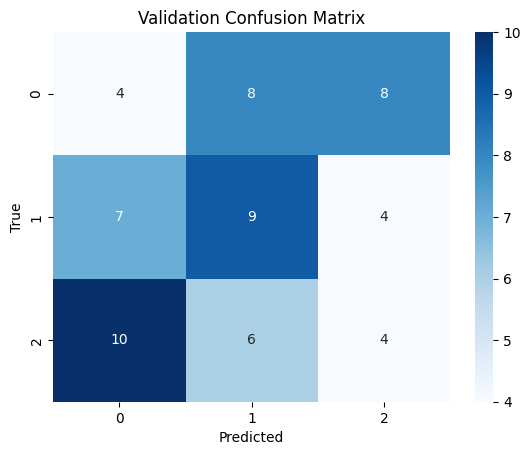

In [37]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

y_pred_val = clf.predict(X_val)

print(f"Validation Accuracy: {accuracy_score(y_val, y_pred_val):.4f}")
print(classification_report(y_val, y_pred_val))

cm = confusion_matrix(y_val, y_pred_val)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Validation Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [38]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=200, random_state=42)
clf.fit(X_tr, y_tr)


RandomForestClassifier(n_estimators=200, random_state=42)

In [39]:
from sklearn.metrics import log_loss

# Predict class probabilities on validation set
y_proba_val = clf.predict_proba(X_val)

# Compute log loss
val_log_loss = log_loss(y_val, y_proba_val)

print(f"Validation Log Loss: {val_log_loss:.4f}")


Validation Log Loss: 1.0999


Accuracy: 0.9433

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.94       100
           1       0.92      0.94      0.93       100
           2       0.96      0.95      0.95       100

    accuracy                           0.94       300
   macro avg       0.94      0.94      0.94       300
weighted avg       0.94      0.94      0.94       300



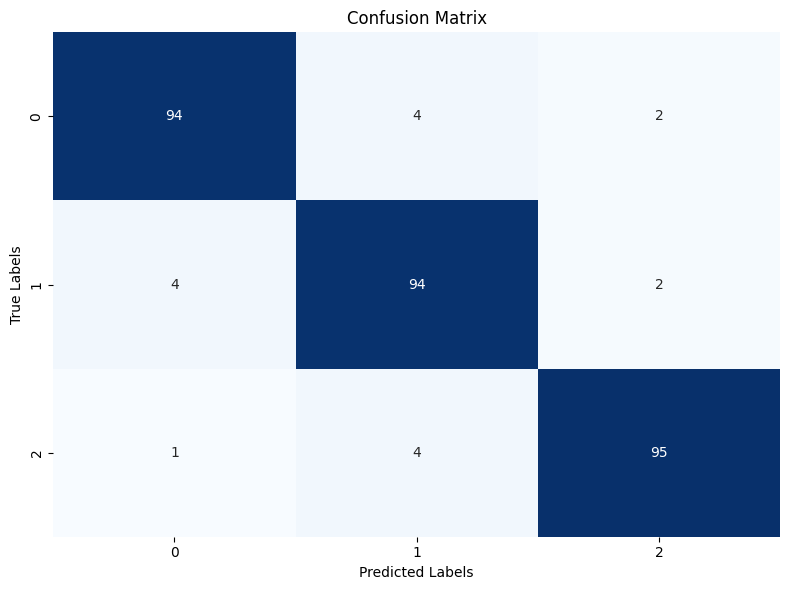

In [25]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predict using trained model
y_pred = clf.predict(X_train)

# Accuracy
acc = accuracy_score(y_train, y_pred)
print(f"Accuracy: {acc:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_train, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_train, y_pred)

# Plot it
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.tight_layout()
plt.show()


In [32]:
# 1️⃣ Ensure X_test is ready
X_test = np.array(final_test_embeddings)
if X_test.ndim == 3 and X_test.shape[1] == 1:
    X_test = X_test.squeeze(1)

# 2️⃣ Get class probabilities using predict_proba
probs = clf.predict_proba(X_test)  # shape: [N, 3]

# 3️⃣ Map columns to class names from LabelEncoder
class_names = le.inverse_transform(np.arange(probs.shape[1]))  # ['cocoa', 'rubber', 'oil']

# 4️⃣ Create DataFrame with unique_id and class probabilities
probs_df = pd.DataFrame(probs, columns=class_names)
probs_df.insert(0, "unique_id", test_uids)  # Add UIDs to front

# 5️⃣ Optional: round for presentation
probs_df = probs_df.round(3)

# Preview
print(probs_df.head())



   unique_id      0      1      2
0  ID_002AIV  0.174  0.699  0.127
1  ID_0042EI  0.491  0.361  0.148
2  ID_008SD4  0.408  0.363  0.229
3  ID_00AQE9  0.254  0.632  0.114
4  ID_00F4A9  0.656  0.303  0.041


In [33]:
probs_df.to_csv("test_probabilities.csv", index=False)
